# 11. TRPO 算法

## 11.1 简介
- 本书之前介绍的基于策略的方法包括策略梯度算法和 Actor-Critic 算法。这些方法虽然简单、直观，但在实际应用过程中会遇到训练不稳定的情况。回顾一下基于策略的方法：参数化智能体的策略，并设计衡量策略好坏的目标函数，通过梯度上升的方法来最大化这个目标函数，使得策略最优。具体来说，假设 $\theta$ 表示策略 $\pi_{\theta}$ 的参数，定义 $J(\theta) = \mathbb{E}_{s_0}[V^{\pi_{\theta}}] = \mathbb{E}_{\pi_0}[\sum_{t = 0}^{\infty} \gamma^tr(s_t, a_t)]$，基于策略的方法的目标是找到 $\theta^* = \arg\max_{\theta}J(\theta)$，策略梯度算法主要沿着 $\nabla_\theta J(\theta)$ 方向迭代更新策略参数 $\theta$。但是这种算法有一个明显的缺点：当策略网络是深度模型时，沿着策略梯度更新参数，很有可能由于步长太长，策略突然显著变差，进而影响训练效果。

- 针对以上问题，我们考虑在更新时找到一块**信任区域**（trust region），在这个区域上更新策略时能够得到某种策略性能的安全性保证，这就是**信任区域策略优化**（trust region policy optimization，TRPO）算法的主要思想。TRPO 算法在 2015 年被提出，它在理论上能够保证策略学习的性能单调性，并在实际应用中取得了比策略梯度算法更好的效果。

## 11.2 策略目标
- 假设当前策略为 $\pi_{\theta}$，参数为 $\theta$。我们考虑如何借助当前的 $\theta$ 找到一个更优的参数 $\theta'$，使得 $J(\theta') \geq J(\theta)$。具体来说，由于初始状态 $s_0$ 的分布和策略无关，因此上述策略 $\pi_{\theta}$ 下的优化目标 $J(\theta)$ 可以写成在新策略 $\pi_{\theta'}$ 的期望形式：

$$
\begin{aligned}
J(\theta) & =\mathbb{E}_{s_0}[V^{\pi_\theta}(s_0)] \\
 & =\mathbb{E}_{\pi_{\theta^{\prime}}}\left[\sum_{t=0}^\infty\gamma^tV^{\pi_\theta}(s_t)-\sum_{t=1}^\infty\gamma^tV^{\pi_\theta}(s_t)\right] \\
 & =-\mathbb{E}_{\pi_{\theta^{\prime}}}\left[\sum_{t=0}^{\infty}\gamma^{t}\left(\gamma V^{\pi_{\theta}}(s_{t+1})-V^{\pi_{\theta}}(s_{t})\right)\right]
\end{aligned}
$$

- 基于以上等式，我们可以推导新旧策略的目标函数之间的差距：

$$
\begin{aligned}
J(\theta^{\prime})-J(\theta) & =\mathbb{E}_{s_0}\left[V^{\pi_{\theta^{\prime}}}(s_0)\right]-\mathbb{E}_{s_0}\left[V^{\pi_\theta}(s_0)\right] \\
 & =\mathbb{E}_{\pi_{\theta^{\prime}}}\left[\sum_{t=0}^\infty\gamma^tr(s_t,a_t)\right]+\mathbb{E}_{\pi_{\theta^{\prime}}}\left[\sum_{t=0}^\infty\gamma^t\left(\gamma V^{\pi_\theta}(s_{t+1})-V^{\pi_\theta}(s_t)\right)\right] \\
 & =\mathbb{E}_{\pi_{\theta^{\prime}}}\left[\sum_{t=0}^\infty\gamma^t\left[r(s_t,a_t)+\gamma V^{\pi_\theta}(s_{t+1})-V^{\pi_\theta}(s_t)\right]\right]
\end{aligned}
$$

- 将时序差分残差定义为优势函数 $A$：

$$
\begin{aligned}
 & =\mathbb{E}_{\pi_{\theta^{\prime}}}\left[\sum_{t=0}^\infty\gamma^tA^{\pi_\theta}(s_t,a_t)\right] \\
 & =\sum_{t=0}^\infty\gamma^t\mathbb{E}_{s_t\sim P_t^{\pi_{\theta^{\prime}}}}\mathbb{E}_{a_t\sim\pi_{\theta^{\prime}}(\cdot|s_t)}\left[A^{\pi_\theta}(s_t,a_t)\right] \\
 & =\frac{1}{1-\gamma}\mathbb{E}_{s\sim\nu^{\pi_{\theta^{\prime}}}}\mathbb{E}_{a\sim\pi_{\theta^{\prime}}(\cdot|s)}\left[A^{\pi_{\theta}}(s,a)\right]
\end{aligned}
$$

- 最后一个等号的成立运用到了状态访问分布的定义：$\nu^\pi(s)=(1-\gamma)\sum_{t=0}^\infty\gamma^tP_t^\pi(s)$，所以只要我们能找到一个新策略，使得 $\mathbb{E}_{s\sim\nu^{\pi_{\theta^{\prime}}}}\mathbb{E}_{a\sim\pi_{\theta^{\prime}}(\cdot|s)}\left[A^{\pi_{\theta}}(s,a)\right]\geq0$，就能保证策略性能单调递增，即 $J(\theta') > J(\theta)$。

- 但是直接求解该式是非常困难的，因为 $\pi_{\theta'}$ 是我们需要求解的策略，但我们又要用它来收集样本。把所有可能的新策略都拿来收集数据，然后判断哪个策略满足上述条件的做法显然是不现实的。于是 TRPO 做了一步近似操作，对状态访问分布进行了相应处理。具体而言，忽略两个策略之间的状态访问分布变化，直接采用旧的策略 $\pi_{\theta}$ 的状态分布，定义如下替代优化目标：

$$
L_\theta(\theta^{\prime})=J(\theta)+\frac{1}{1-\gamma}\mathbb{E}_{s\sim\nu^{\pi_\theta}}\mathbb{E}_{a\sim\pi_{\theta^{\prime}}(\cdot|s)}\left[A^{\pi_\theta}(s,a)\right]
$$

- 当新旧策略非常接近时，状态访问分布变化很小，这么近似是合理的。其中，动作仍然用新策略 $\pi_{\theta'}$ 采样得到，我们可以用重要性采样对动作分布进行处理：

$$
L_\theta(\theta^{\prime})=J(\theta)+\mathbb{E}_{s\sim\nu^{\pi_\theta}}\mathbb{E}_{a\sim\pi_\theta(\cdot|s)}\left[\frac{\pi_{\theta^{\prime}}(a|s)}{\pi_\theta(a|s)}A^{\pi_\theta}(s,a)\right]
$$

- 这样，我们就可以基于旧策略 $\pi_{\theta}$ 已经采样处的数据来估计并优化新策略 $\pi_{\theta'}$ 了。为了保证新旧策略足够接近，TRPO 使用了**库尔贝克-莱布勒**（Kullback-Leibler，KL）散度来衡量策略之间的距离，并给出了整体的优化公式：

$$
\begin{aligned}
 & \max_{\theta^{\prime}}L_{\theta}(\theta^{\prime}) \\
 & \mathrm{s.t.}\mathbb{E}_{s\sim\nu^{\pi_{\theta_{k}}}}[D_{KL}(\pi_{\theta_{k}}(\cdot|s),\pi_{\theta^{\prime}}(\cdot|s))]\leq\delta
\end{aligned}
$$

- 这里的不等式约束定义了策略空间中的一个 KL 球，被称为信任区域。在这个区域中，可以认为当前学习策略和环境交互的状态分布与上一轮策略最后采样的状态分布一致，进而可以基于一步行动的重要性采样方法使当前学习策略稳定提升。TRPO 背后的原理如图 11-1 所示。

<div align="center">
    <img src="./image/11-1.png">
    <center>图 11-1 TRPO原理示意图</center>
</div> 

- 左图表示当完全不设置信任区域时，策略的梯度更新可能导致策略的性能骤降；右图表示当设置了信任区域时，可以保证每次策略的梯度更新都能来带性能的提升

## 11.3 近似求解
- 直接求解上式带约束的优化问题比较麻烦，TRPO 在其具体实现中做了一步近似操作来快速求解。为方便起见，我们在接下来的式子中用 $\theta_k$ 代替之前的 $\theta$，表示这是第 $k$ 次迭代之后的策略。首先对目标函数和约束在 $\theta_k$ 进行泰勒展开，分别使用 1阶、2阶进行近似：

$$
\mathbb{E}_{s\sim\nu^{\pi_{\theta_{k}}}}\mathbb{E}_{a\sim\pi_{\theta_{k}}(\cdot|s)}\left[\frac{\pi_{\theta^{\prime}}(a|s)}{\pi_{\theta_{k}}(a|s)}A^{\pi_{\theta_{k}}}(s,a)\right]\approx g^{T}(\theta^{\prime}-\theta_{k})\mathbb{E}_{s\sim\nu^{\pi_{\theta_{k}}}}[D_{KL}(\pi_{\theta_{k}}(\cdot|s),\pi_{\theta^{\prime}}(\cdot|s))]\approx\frac{1}{2}(\theta^{\prime}-\theta_{k})^{T}H(\theta^{\prime}-\theta_{k})
$$

- 其中 $g=\nabla_{\theta^{\prime}}\mathbb{E}_{s\sim\nu^{\pi_{\theta_k}}}\mathbb{E}_{a\sim\pi_{\theta_k}(\cdot|s)}\left[\frac{\pi_{\theta^{\prime}}(a|s)}{\pi_{\theta_k}(a|s)}A^{\pi_{\theta_k}}(s,a)\right]$，表示目标函数的梯度，$H=\mathbf{H}[\mathbb{E}_{s\sim\nu^{\pi_{\theta_k}}}[D_{KL}(\pi_{\theta_k}(\cdot|s),\pi_{\theta^{\prime}}(\cdot|s))]]$ 表示策略之间平均 KL 距离的**黑塞矩阵（Hessian matrix）。

- 于是我们的优化目标变成了：

$$
\theta_{k+1}=\underset{\theta^{\prime}}{\operatorname*{\arg\max}}g^T(\theta^{\prime}-\theta_k)\quad\mathrm{s.t.}\quad\frac{1}{2}(\theta^{\prime}-\theta_k)^TH(\theta^{\prime}-\theta_k)\leq\delta
$$

- 此时，我们可以用**卡罗需-库恩-塔克**（Karush-Kuhn-Tucker，KKT）条件直接导出上述问题的解：

$$
\theta_{k+1}=\theta_k+\sqrt{\frac{2\delta}{g^TH^{-1}g}}H^{-1}g
$$

## 11.4 共轭梯度
- 一般来说，用神经网络表示的策略函数的参数数量都是成千上万的，计算和存储黑塞矩阵 $H$ 的逆矩阵会耗费大量的内存资源和时间。TRPO 通过**共轭梯度法**（conjugate gradient method）回避了这个问题，它的核心思想是直接计算 $x = H^{-1}g$，$x$ 即参数更新方向。假设满足 KL 距离约束的参数更新时的最大步长为 $\beta$，于是，根据 KL 距离约束条件，有 $\frac{1}{2}(\beta x)^TH(\beta x)=\delta\frac{1}{2}(\beta x)^TH(\beta x)=\delta$，得到 $\beta=\sqrt{\frac{2\delta}{x^{T}Hx}}$。因此，此时参数更新方式为：

$$
\theta_{k+1}=\theta_k+\sqrt{\frac{2\delta}{x^THx}}x
$$

- 因此，只要可以直接计算 $x = H^{-1}g$，就可以根据该式更新参数，问题转化为解 $Hx = g$。实际上 $H$ 为对称正定矩阵，所以我们可以使用共轭梯度法来求解。共轭梯度法的具体流程如下：
    - 初始化 $r_0 = g - Hx_0, p_0 = r_0, x_0 = 0$
    - for $k = 0 \to N$ do:
        - $\alpha_k=\frac{r_k^Tr_k}{p_k^THp_k}$
        - $x_{k+1}=x_k+\alpha_kp_k$
        - $r_{k+1}=r_k-\alpha_kHp_k$
        - 如果 $r_{k+1}^Tr_{k+1}$ 非常小，则退出循环
        - $\beta_{k}=\frac{r_{k+1}^Tr_{k+1}}{r_k^Tr_k}$
        - $p_{k+1}=r_{k+1}+\beta_kp_k$
    - end for
    - 输出 $x_{N+1}$
    
- 在共轭梯度运算过程中，直接计算 $\alpha_k$ 和 $r_{k+1}$ 需要计算和存储黑塞矩阵 $H$。为了避免这种大矩阵的出现，我们只计算 $H_x$ 向量，而不直接计算和存储 $H$ 矩阵。这样做比较容易，因为对于任意的列向量 $v$，容易验证：

$$
Hv=\nabla_\theta\left(\left(\nabla_\theta(D_{KL}^{\nu^{\pi_{\theta_k}}}(\pi_{\theta_k},\pi_{\theta^{\prime}}))\right)^T\right)v=\nabla_\theta\left(\left(\nabla_\theta(D_{KL}^{\nu^{\pi_{\theta_k}}}(\pi_{\theta_k},\pi_{\theta^{\prime}}))\right)^Tv\right)
$$

- 即先用梯度和向量 $v$ 点乘后计算梯度。

## 11.5 线性搜索
- 由于TRPO 算法用到了泰勒展开的 1 阶和 2 阶近似，这并非精准求解，因此，$\theta'$ 可能未必比 $\theta_k$ 好，或未必能满足 KL 散度限制。TRPO 在每次迭代的最后进行一次线性搜索（Line Search），以确保找到满足条件。具体来说，就是找到一个最小的非负整数 $i$，使得按照：

$$
\theta_{k+1}=\theta_k+\alpha^i\sqrt{\frac{2\delta}{x^THx}}x
$$

- 求出的 $\theta_{k+1}$ 依然满足最初的 KL 散度限制，并且确实能够提升目标函数 $L_{\theta_k}$，这其中 $\alpha \in (0,1)$ 是一个决定线性搜索长度的超参数。

- 至此，我们已经基本上清楚了 TRPO 算法的大致过程，它具体的算法流程如下：
    - 初始化策略网络参数 $\theta$，价值网络参数 $\omega$
    - for 序列 $e = 1 \to E$ do:
        - 用当前策略 $\pi_{\theta}$ 采样轨迹 $\{s_1, a_1, r_1, s_2, a_2, r_2\}$
        - 根据收集到的数据和价值网络估计每个状态动作对的优势 $A(s,a)$
        - 计算策略目标函数的梯度 $g$
        - 用共轭梯度法计算 $x = H^{-1}g$
        - 用线性搜索找到一个 $i$ 值，并更新策略网络参数 $\theta_{k+1}=\theta_{k}+\alpha^{i}\sqrt{\frac{2\delta}{x^{T}Hx}}x$，其中 $i \in \{1,2,...K\}$ 为能提升策略并满足 KL 距离限制的最小整数
        - 更新价值网络参数（与 Actor-Critic 中的更新方法相同）
    - end for
    
## 11.6 广义优势估计
- 从 11.5 节中，我们尚未得知如何估计优势函数 $A$。目前比较常用的一种方法为**广义优势估计**（Generalized Advantage Estimation，GAE），接下来我们简单介绍一下 GAE 的做法。首先，用 $\delta_t=r_t+\gamma V(s_{t+1})-V(s_t)$ 表示时序差分误差，其中 $V$ 是一个已经学习的状态价值函数。于是，根据多步时序差分的思想，有：

$$
\begin{aligned}
A_{t}^{(1)} & =\delta_{t} & & =-V(s_t)+r_t+\gamma V(s_{t+1}) \\
A_{t}^{(2)} & =\delta_t+\gamma\delta_{t+1} & & =-V(s_t)+r_t+\gamma r_{t+1}+\gamma^2V(s_{t+2}) \\
A_{t}^{(3)} & =\delta_t+\gamma\delta_{t+1}+\gamma^2\delta_{t+2} & & =-V(s_t)+r_t+\gamma r_{t+1}+\gamma^2r_{t+2}+\gamma^3V(s_{t+3}) \\
A_{t}^{(k)} & =\sum_{l=0}^{k-1}\gamma^l\delta_{t+l} & & =-V(s_t)+r_t+\gamma r_{t+1}+\ldots+\gamma^{k-1}r_{t+k-1}+\gamma^kV(s_{t+k})
\end{aligned}
$$

- 然后，GAE 将这些不同步数的优势估计进行指数加权平均：

$$
\begin{aligned}
A_{t}^{GAE} & =(1-\lambda)(A_t^{(1)}+\lambda A_t^{(2)}+\lambda^2A_t^{(3)}+\cdots) \\
 & =(1-\lambda)(\delta_t+\lambda(\delta_t+\gamma\delta_{t+1})+\lambda^2(\delta_t+\gamma\delta_{t+1}+\gamma^2\delta_{t+2})+\cdots) \\
 & =(1-\lambda)(\delta(1+\lambda+\lambda^2+\cdots)+\gamma\delta_{t+1}(\lambda+\lambda^2+\lambda^3+\cdots)+\gamma \\
 & =(1-\lambda)\left(\delta_t\frac{1}{1-\lambda}+\gamma\delta_{t+1}\frac{\lambda}{1-\lambda}+\gamma^2\delta_{t+2}\frac{\lambda^2}{1-\lambda}+\cdots\right) \\
 & =\sum_{l=0}^\infty(\gamma\lambda)^l\delta_{t+l}
\end{aligned}
$$

- 其中，$\lambda \in [0,1]$ 是在 GAE 中额外引入的一个超参数。当 $\lambda = 0$ 时，$A_t^{GAE}=\delta_t=r_t+\gamma V(s_{t+1})-V(s_t)$，也即是仅仅只看一步差分得到的优势；当 $\lambda = 1$ 时，$A_t^{GAE}=\sum_{l=0}^\infty\gamma^l\delta_{t+l}=\sum_{l=0}^\infty\gamma^lr_{t+l}-V(s_t)$，则是看每一步差分得到优势的完全平均值。

- 下面一段是 GAE 的代码，给定 $\gamma, \lambda$ 以及每个时间步的 $\delta_t$ 之后，我们可以根据公式直接进行优势估计。

In [1]:
def compute_advantage(gamma, lmbda, td_delta):
    td_delta = td_delta.detach().numpy()
    advantage_list = []
    advantage = 0.0
    for delta in td_delta[::-1]:
        advantage = gamma * lmbda * advantage + delta
        advantage_list.append(advantage)
    advantage_list.reverse()
    return torch.tensor(advantage_list, dtype=torch.float)

## 11.7 TRPO 代码实践
- 本节将使用支持与离散和连续两种动作交互的环境来进行 TRPO 的实验。我们使用的第一个环境是车杆（CartPole），第二个环境是倒立摆（Inverted Pendulum）。

- 首先导入一些必要的库。

In [2]:
import torch
import numpy as np
import gym
import matplotlib.pyplot as plt
import torch.nn.functional as F
import rl_utils
import copy

- 然后定义策略网络和价值网络（与 Actor-Critic 算法一样）

In [3]:
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x), dim=1)


class ValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super(ValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)


class TRPO:
    """ TRPO算法 """
    def __init__(self, hidden_dim, state_space, action_space, lmbda,
                 kl_constraint, alpha, critic_lr, gamma, device):
        state_dim = state_space.shape[0]
        action_dim = action_space.n
        # 策略网络参数不需要优化器更新
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(),
                                                 lr=critic_lr)
        self.gamma = gamma
        self.lmbda = lmbda  # GAE参数
        self.kl_constraint = kl_constraint  # KL距离最大限制
        self.alpha = alpha  # 线性搜索参数
        self.device = device

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        probs = self.actor(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()

    def hessian_matrix_vector_product(self, states, old_action_dists, vector):
        # 计算黑塞矩阵和一个向量的乘积
        new_action_dists = torch.distributions.Categorical(self.actor(states))
        kl = torch.mean(
            torch.distributions.kl.kl_divergence(old_action_dists,
                                                 new_action_dists))  # 计算平均KL距离
        kl_grad = torch.autograd.grad(kl,
                                      self.actor.parameters(),
                                      create_graph=True)
        kl_grad_vector = torch.cat([grad.view(-1) for grad in kl_grad])
        # KL距离的梯度先和向量进行点积运算
        kl_grad_vector_product = torch.dot(kl_grad_vector, vector)
        grad2 = torch.autograd.grad(kl_grad_vector_product,
                                    self.actor.parameters())
        grad2_vector = torch.cat([grad.view(-1) for grad in grad2])
        return grad2_vector

    def conjugate_gradient(self, grad, states, old_action_dists):  # 共轭梯度法求解方程
        x = torch.zeros_like(grad)
        r = grad.clone()
        p = grad.clone()
        rdotr = torch.dot(r, r)
        for i in range(10):  # 共轭梯度主循环
            Hp = self.hessian_matrix_vector_product(states, old_action_dists,
                                                    p)
            alpha = rdotr / torch.dot(p, Hp)
            x += alpha * p
            r -= alpha * Hp
            new_rdotr = torch.dot(r, r)
            if new_rdotr < 1e-10:
                break
            beta = new_rdotr / rdotr
            p = r + beta * p
            rdotr = new_rdotr
        return x

    def compute_surrogate_obj(self, states, actions, advantage, old_log_probs,
                              actor):  # 计算策略目标
        log_probs = torch.log(actor(states).gather(1, actions))
        ratio = torch.exp(log_probs - old_log_probs)
        return torch.mean(ratio * advantage)

    def line_search(self, states, actions, advantage, old_log_probs,
                    old_action_dists, max_vec):  # 线性搜索
        old_para = torch.nn.utils.convert_parameters.parameters_to_vector(
            self.actor.parameters())
        old_obj = self.compute_surrogate_obj(states, actions, advantage,
                                             old_log_probs, self.actor)
        for i in range(15):  # 线性搜索主循环
            coef = self.alpha**i
            new_para = old_para + coef * max_vec
            new_actor = copy.deepcopy(self.actor)
            torch.nn.utils.convert_parameters.vector_to_parameters(
                new_para, new_actor.parameters())
            new_action_dists = torch.distributions.Categorical(
                new_actor(states))
            kl_div = torch.mean(
                torch.distributions.kl.kl_divergence(old_action_dists,
                                                     new_action_dists))
            new_obj = self.compute_surrogate_obj(states, actions, advantage,
                                                 old_log_probs, new_actor)
            if new_obj > old_obj and kl_div < self.kl_constraint:
                return new_para
        return old_para

    def policy_learn(self, states, actions, old_action_dists, old_log_probs,
                     advantage):  # 更新策略函数
        surrogate_obj = self.compute_surrogate_obj(states, actions, advantage,
                                                   old_log_probs, self.actor)
        grads = torch.autograd.grad(surrogate_obj, self.actor.parameters())
        obj_grad = torch.cat([grad.view(-1) for grad in grads]).detach()
        # 用共轭梯度法计算x = H^(-1)g
        descent_direction = self.conjugate_gradient(obj_grad, states,
                                                    old_action_dists)

        Hd = self.hessian_matrix_vector_product(states, old_action_dists,
                                                descent_direction)
        max_coef = torch.sqrt(2 * self.kl_constraint /
                              (torch.dot(descent_direction, Hd) + 1e-8))
        new_para = self.line_search(states, actions, advantage, old_log_probs,
                                    old_action_dists,
                                    descent_direction * max_coef)  # 线性搜索
        torch.nn.utils.convert_parameters.vector_to_parameters(
            new_para, self.actor.parameters())  # 用线性搜索后的参数更新策略

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(
            self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)
        td_target = rewards + self.gamma * self.critic(next_states) * (1 -
                                                                       dones)
        td_delta = td_target - self.critic(states)
        advantage = compute_advantage(self.gamma, self.lmbda,
                                      td_delta.cpu()).to(self.device)
        old_log_probs = torch.log(self.actor(states).gather(1,
                                                            actions)).detach()
        old_action_dists = torch.distributions.Categorical(
            self.actor(states).detach())
        critic_loss = torch.mean(
            F.mse_loss(self.critic(states), td_target.detach()))
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()  # 更新价值函数
        # 更新策略函数
        self.policy_learn(states, actions, old_action_dists, old_log_probs,
                          advantage)

- 接下来在车杆环境中训练 TRPO，并将结果可视化。

/home/wxl/anaconda3/envs/d2l/lib/python3.10/site-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/home/wxl/anaconda3/envs/d2l/lib/python3.10/site-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/wxl/anaconda3/envs/d2l/lib/python3.10/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/wxl/anaconda3/envs/d2l/lib/python3.10/site-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecate

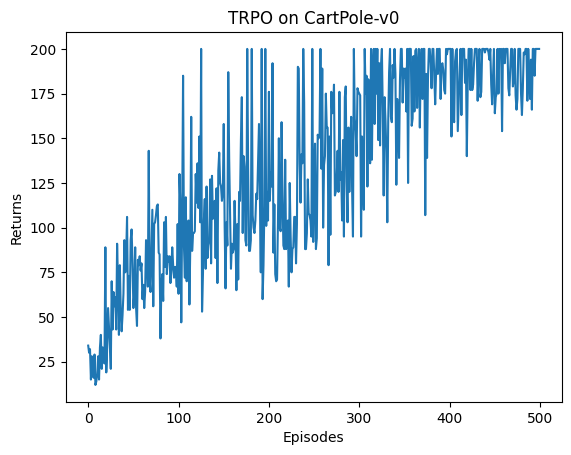

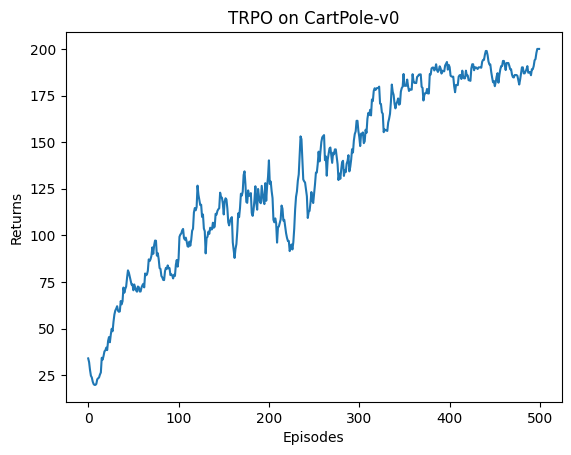

In [4]:
num_episodes = 500
hidden_dim = 128
gamma = 0.98
lmbda = 0.95
critic_lr = 1e-2
kl_constraint = 0.0005
alpha = 0.5
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

env_name = 'CartPole-v0'
env = gym.make(env_name)
env.seed(0)
torch.manual_seed(0)
agent = TRPO(hidden_dim, env.observation_space, env.action_space, lmbda,
             kl_constraint, alpha, critic_lr, gamma, device)
return_list = rl_utils.train_on_policy_agent(env, agent, num_episodes)

episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('TRPO on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('TRPO on {}'.format(env_name))
plt.show()

- TRPO 在车杆环境中很快收敛，展现了十分优秀的性能效果。

- 接下来我们尝试倒立摆环境，由于它是与连续动作交互的环境，我们需要对上面的代码做一定的修改。对于策略网络，因为环境是连续动作的，所以策略网络分别输出表示动作分布的高斯分布的均值和标准差。

In [5]:
class PolicyNetContinuous(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNetContinuous, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc_mu = torch.nn.Linear(hidden_dim, action_dim)
        self.fc_std = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        mu = 2.0 * torch.tanh(self.fc_mu(x))
        std = F.softplus(self.fc_std(x))
        return mu, std  # 高斯分布的均值和标准差


class TRPOContinuous:
    """ 处理连续动作的TRPO算法 """
    def __init__(self, hidden_dim, state_space, action_space, lmbda,
                 kl_constraint, alpha, critic_lr, gamma, device):
        state_dim = state_space.shape[0]
        action_dim = action_space.shape[0]
        self.actor = PolicyNetContinuous(state_dim, hidden_dim,
                                         action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(),
                                                 lr=critic_lr)
        self.gamma = gamma
        self.lmbda = lmbda
        self.kl_constraint = kl_constraint
        self.alpha = alpha
        self.device = device

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        mu, std = self.actor(state)
        action_dist = torch.distributions.Normal(mu, std)
        action = action_dist.sample()
        return [action.item()]

    def hessian_matrix_vector_product(self,
                                      states,
                                      old_action_dists,
                                      vector,
                                      damping=0.1):
        mu, std = self.actor(states)
        new_action_dists = torch.distributions.Normal(mu, std)
        kl = torch.mean(
            torch.distributions.kl.kl_divergence(old_action_dists,
                                                 new_action_dists))
        kl_grad = torch.autograd.grad(kl,
                                      self.actor.parameters(),
                                      create_graph=True)
        kl_grad_vector = torch.cat([grad.view(-1) for grad in kl_grad])
        kl_grad_vector_product = torch.dot(kl_grad_vector, vector)
        grad2 = torch.autograd.grad(kl_grad_vector_product,
                                    self.actor.parameters())
        grad2_vector = torch.cat(
            [grad.contiguous().view(-1) for grad in grad2])
        return grad2_vector + damping * vector

    def conjugate_gradient(self, grad, states, old_action_dists):
        x = torch.zeros_like(grad)
        r = grad.clone()
        p = grad.clone()
        rdotr = torch.dot(r, r)
        for i in range(10):
            Hp = self.hessian_matrix_vector_product(states, old_action_dists,
                                                    p)
            alpha = rdotr / torch.dot(p, Hp)
            x += alpha * p
            r -= alpha * Hp
            new_rdotr = torch.dot(r, r)
            if new_rdotr < 1e-10:
                break
            beta = new_rdotr / rdotr
            p = r + beta * p
            rdotr = new_rdotr
        return x

    def compute_surrogate_obj(self, states, actions, advantage, old_log_probs,
                              actor):
        mu, std = actor(states)
        action_dists = torch.distributions.Normal(mu, std)
        log_probs = action_dists.log_prob(actions)
        ratio = torch.exp(log_probs - old_log_probs)
        return torch.mean(ratio * advantage)

    def line_search(self, states, actions, advantage, old_log_probs,
                    old_action_dists, max_vec):
        old_para = torch.nn.utils.convert_parameters.parameters_to_vector(
            self.actor.parameters())
        old_obj = self.compute_surrogate_obj(states, actions, advantage,
                                             old_log_probs, self.actor)
        for i in range(15):
            coef = self.alpha**i
            new_para = old_para + coef * max_vec
            new_actor = copy.deepcopy(self.actor)
            torch.nn.utils.convert_parameters.vector_to_parameters(
                new_para, new_actor.parameters())
            mu, std = new_actor(states)
            new_action_dists = torch.distributions.Normal(mu, std)
            kl_div = torch.mean(
                torch.distributions.kl.kl_divergence(old_action_dists,
                                                     new_action_dists))
            new_obj = self.compute_surrogate_obj(states, actions, advantage,
                                                 old_log_probs, new_actor)
            if new_obj > old_obj and kl_div < self.kl_constraint:
                return new_para
        return old_para

    def policy_learn(self, states, actions, old_action_dists, old_log_probs,
                     advantage):
        surrogate_obj = self.compute_surrogate_obj(states, actions, advantage,
                                                   old_log_probs, self.actor)
        grads = torch.autograd.grad(surrogate_obj, self.actor.parameters())
        obj_grad = torch.cat([grad.view(-1) for grad in grads]).detach()
        descent_direction = self.conjugate_gradient(obj_grad, states,
                                                    old_action_dists)
        Hd = self.hessian_matrix_vector_product(states, old_action_dists,
                                                descent_direction)
        max_coef = torch.sqrt(2 * self.kl_constraint /
                              (torch.dot(descent_direction, Hd) + 1e-8))
        new_para = self.line_search(states, actions, advantage, old_log_probs,
                                    old_action_dists,
                                    descent_direction * max_coef)
        torch.nn.utils.convert_parameters.vector_to_parameters(
            new_para, self.actor.parameters())

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)
        rewards = (rewards + 8.0) / 8.0  # 对奖励进行修改,方便训练
        td_target = rewards + self.gamma * self.critic(next_states) * (1 -
                                                                       dones)
        td_delta = td_target - self.critic(states)
        advantage = compute_advantage(self.gamma, self.lmbda,
                                      td_delta.cpu()).to(self.device)
        mu, std = self.actor(states)
        old_action_dists = torch.distributions.Normal(mu.detach(),
                                                      std.detach())
        old_log_probs = old_action_dists.log_prob(actions)
        critic_loss = torch.mean(
            F.mse_loss(self.critic(states), td_target.detach()))
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()
        self.policy_learn(states, actions, old_action_dists, old_log_probs,
                          advantage)

- 接下来我们在倒立摆环境下训练连续动作版本的 TRPO 算法，并观测它的训练性能曲线。本段代码的完整运行需要一定的时间。

/home/wxl/anaconda3/envs/d2l/lib/python3.10/site-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/wxl/anaconda3/envs/d2l/lib/python3.10/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/wxl/anaconda3/envs/d2l/lib/python3.10/site-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(
Iteration 9: 100%|██████████| 200/200 [00:47<00:00,  4.19it/s, episode=2000, return=-1137.125]


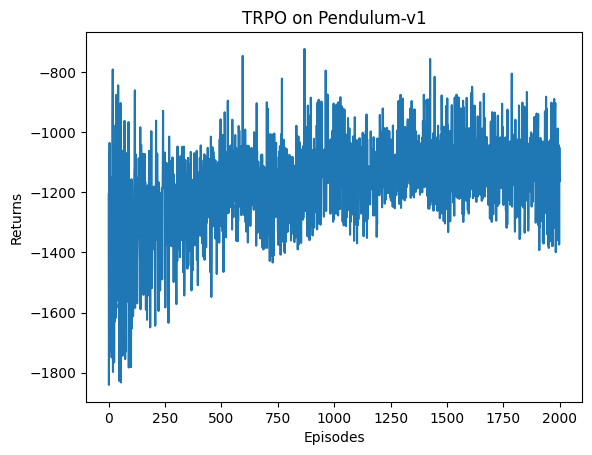

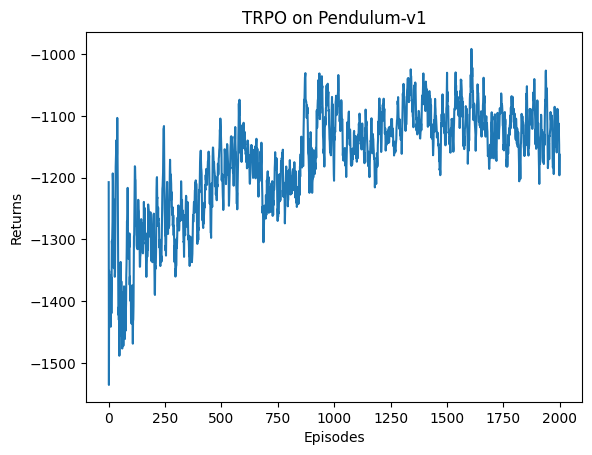

In [7]:
num_episodes = 2000
hidden_dim = 128
gamma = 0.9
lmbda = 0.9
critic_lr = 1e-2
kl_constraint = 0.00005
alpha = 0.5
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

env_name = 'Pendulum-v1'
env = gym.make(env_name)
env.seed(0)
torch.manual_seed(0)
agent = TRPOContinuous(hidden_dim, env.observation_space, env.action_space,
                       lmbda, kl_constraint, alpha, critic_lr, gamma, device)
return_list = rl_utils.train_on_policy_agent(env, agent, num_episodes)

episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('TRPO on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('TRPO on {}'.format(env_name))
plt.show()

- 用 TRPO 在与连续动作交互的倒立摆环境中能够取得非常不错的效果，这说明 TRPO 中的信任区域优化方法在离散和连续动作空间都能有效工作。

## 11.8 总结
- 本章讲解了 TRPO 算法，并分别在离散动作和连续动作交互的环境中进行了实验。TRPO 算法属于在线策略学习方法，每次策略训练仅使用上一轮策略采样的数据，是基于策略的深度强化学习算法中十分有代表性的工作之一。直觉性地理解，TRPO 给出的观点是：由于策略的改变导致数据分布的改变，这大大影响深度模型实现的策略网络的学习效果，所以通过划定一个可信任的策略学习区域，保证策略学习的稳定性和有效性。

- TRPO 算法是比较难掌握的一种强化学习算法，需要较好的数学基础。读者若在学习过程中遇到困难，可自行查阅相关资料。TRPO 有一些后续工作，其中最著名的当属 PPO，我们将在第 12 章进行介绍。